In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import base64
import csv
import os
import seaborn as sns
import numpy as np
from glob import glob
from shutil import copyfile

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [1]:
import os, keras

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical

from datetime import datetime
from matplotlib import pyplot as plt

%matplotlib inline

Using Theano backend.


In [2]:
import numpy as np

from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

# Finetune VGG

In [2]:
PROJECT_DIR  = '/home/ubuntu/Extracting-food-preferences'
PICTURES_DIR = '/home/ubuntu/Extracting-food-preferences/classification_with_pics'

In [3]:
PROJECT_DIR  = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
PICTURES_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences\\classification_with_pics'

In [4]:
%cd $PROJECT_DIR

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences


In [5]:
def vgg_preprocess(x):
    x = x - np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    return x[:, ::-1] # reverse axis rgb->bgr

In [6]:
def VGG16():
    
    """
    Model is based on 
    https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
    ImageNet Pretrained Weights 
    https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing

    """
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    # Loads ImageNet pre-trained data
    model.load_weights('imagenet_weights/vgg16.h5')

    return model

In [5]:
#%cd $PICTURES_DIR

path = PICTURES_DIR #+ '/sample'
results_path=path + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/ubuntu/Extracting-food-preferences/classification_with_pics


In [7]:
# on local home computer

#%cd $PICTURES_DIR

path = PICTURES_DIR + '\\sample\\'
results_path=path + '\\results\\'
train_path=path + '\\train\\'
valid_path=path + '\\valid\\'

model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [8]:
%cd $PROJECT_DIR

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences


In [10]:
#Set constants
batch_size=25
no_of_epochs=1

In [11]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
generator = image.ImageDataGenerator()
val_batches = generator.flow_from_directory(valid_path, 
                                  target_size=(224,224), 
                                  class_mode='categorical',
                                  batch_size=batch_size, 
                                  shuffle=False)
batches     = generator.flow_from_directory(train_path, 
                                  target_size=(224,224), 
                                  class_mode='categorical',
                                  batch_size=batch_size, 
                                  shuffle=False)

Found 50 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [24]:
#import Vgg16 
vgg = VGG16()

In [25]:
vgg.layers.pop()
vgg.outputs = [vgg.layers[-1].output]
vgg.layers[-1].outbound_nodes = []
for layer in vgg.layers: layer.trainable=False
vgg.add(Dense(batches.nb_class, activation='softmax'))
vgg.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
vgg.model.optimizer.lr = 0.01

In [27]:
start = datetime.now()
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: {}".format(epoch))
    history = vgg.fit_generator(batches, 
                                samples_per_epoch=batches.nb_sample, 
                                nb_epoch=1,
                                validation_data=val_batches, 
                                nb_val_samples=val_batches.nb_sample)
    latest_weights_filename = 'ft{}_new.h5'.format(epoch)
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed {} fit operations".format(no_of_epochs))
end = datetime.now()
total = end - start
print('Time to run the script on GPU is {}'.format(total))

Running epoch: 0
Epoch 1/1
200/200 [==============================] - 114s - loss: 8.3006 - acc: 0.4250 - val_loss: 6.4472 - val_acc: 0.6000
Completed 1 fit operations
Time to run the script on GPU is 0:02:01.155531


In [28]:
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_40[0][0]           
___________________________________________________________________________________________

In [ ]:
start = datetime.now()
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: {}".format(epoch))
    history = vgg.fit2(batches, val_batches, nb_epoch=5)
    latest_weights_filename = 'ft{}.h5'.format(epoch)
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed {} fit operations".format(no_of_epochs))
end = datetime.now()
total = end - start
print('Time to run the script on GPU is {}'.format(total))

Running epoch: 0
Epoch 1/5
153087/153087 [==============================] - 3314s - loss: 7.5161 - acc: 0.5250 - val_loss: 7.4017 - val_acc: 0.5341
Epoch 2/5
153087/153087 [==============================] - 3337s - loss: 7.5614 - acc: 0.5262 - val_loss: 7.5243 - val_acc: 0.5287
Epoch 3/5
153087/153087 [==============================] - 3318s - loss: 7.3750 - acc: 0.5373 - val_loss: 7.2490 - val_acc: 0.5456
Epoch 4/5
153087/153087 [==============================] - 3319s - loss: 7.4898 - acc: 0.5315 - val_loss: 7.4160 - val_acc: 0.5355
Epoch 5/5
153087/153087 [==============================] - 3352s - loss: 7.4270 - acc: 0.5352 - val_loss: 7.4094 - val_acc: 0.5360
Running epoch: 1
Epoch 1/5
  5675/153087 [>.............................] - ETA: 2678s - loss: 7.4675 - acc: 0.5316

KeyboardInterrupt: 

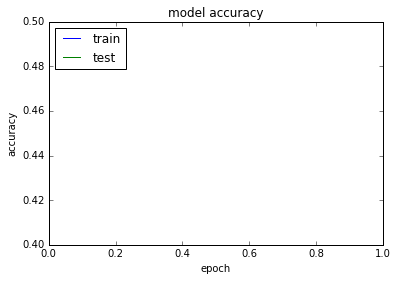

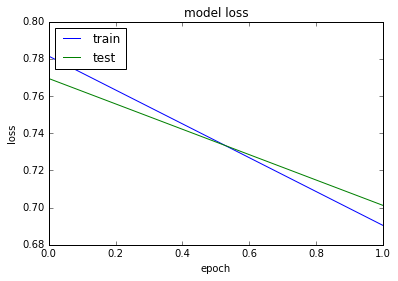

In [79]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()